Import libraries

In [2]:
# Import all necessary libraries
import torch
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt
import hydra
from fw_jsbgym.trim.trim_point import TrimPoint
from fw_jsbgym.utils import conversions
from fw_jsbgym.utils import jsbsim_properties as prp
from scipy.spatial.transform import Rotation as R

# Add the TDMPC2 module path
current_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(f'{current_dir}/../agents/tdmpc2/tdmpc2/')

from fw_flightcontrol.agents.tdmpc2.tdmpc2.common.parser import parse_cfg
from fw_flightcontrol.agents.tdmpc2.tdmpc2.envs import make_env
from fw_flightcontrol.agents.tdmpc2.tdmpc2.tdmpc2 import TDMPC2
from fw_flightcontrol.eval.waypoint_tracking.utils import metrics

%matplotlib inline
print("Imports Successful")

Imports Successful


/opt/anaconda3/envs/tdmpc/lib/python3.10/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Setup exp config

In [3]:
# Specify the relative path to your config directory from the notebook location
config_path = "../../config"  # Adjust this path to where your configs are stored

np.set_printoptions(precision=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"**** Using Device: {device} ****")

# Define a wrapper for parse_cfg to avoid the HydraConfig issue
def notebook_parse_cfg(cfg, cwd=None):
    # Save original function for later restoration
    original_get_cwd = hydra.utils.get_original_cwd

    # Create a temporary replacement function
    def mock_get_cwd():
        return cwd or os.getcwd()

    # Replace the function temporarily
    hydra.utils.get_original_cwd = mock_get_cwd

    try:
        # Call the actual parse_cfg
        result = parse_cfg(cfg)
        return result
    finally:
        # Restore the original function
        hydra.utils.get_original_cwd = original_get_cwd


# Initialize Hydra
with hydra.initialize(version_base=None, config_path=config_path):
    cfg = hydra.compose(
        config_name="tdmpc2_default",
        overrides=[
            "rl.task=WaypointTracking",
            "rl.seed=10",
            "env.jsbsim.render_mode=log",
            "env/task/reward=wp_dist",
            "env/jsbsim=turbonly_eval",
            "rl.checkpoint='../../models/train/tdmpc2/2989/tdmpc2_wp_multigoals360_rtanh0.003_dist-8_1.5e6_2989.pt'",
        ],
    )

    # Use our wrapper instead of direct parse_cfg
    current_dir = os.getcwd()
    cfg.rl = notebook_parse_cfg(cfg.rl, current_dir)


# Now you can use cfg as you were doing
cfg_rl = cfg.rl
cfg_sim = cfg.env.jsbsim

print("CELL PASSED")

**** Using Device: cuda ****
Seed provided, using seed from config: 10
CELL PASSED


Setup paths and targets

In [ ]:
# env setup
env = make_env(cfg)

trim = TrimPoint("x8")
trim_action = torch.tensor([trim.aileron, trim.elevator, trim.throttle])

# print the current directory
print(f"Current directory: {current_dir}")

# Load agent
agent = TDMPC2(cfg.rl)
assert os.path.exists(
    cfg.rl.checkpoint
), f"Checkpoint {cfg.rl.checkpoint} not found! Must be a valid filepath."
agent.load(cfg.rl.checkpoint)

# get the checkpoint file name (without the parent directories, and the .pt at the end)
checkpoint_name = '_'.join(cfg.rl.checkpoint.split('/')[-1].split('_'))[:-3]
print(f"**** Using Checkpoint: {checkpoint_name} ****")

jsbsim_seeds = np.load(f'targets/jsbsim_seeds.npy')
cfg_sim.eval_sim_options.seed = float(jsbsim_seeds[0])

if cfg_sim.eval_sim_options.atmosphere.severity == "all":
    severity_range = ["off", "light", "moderate", "severe"]
else:
    severity_range = [cfg_sim.eval_sim_options.atmosphere.severity]

atmo_type: str = ''
if cfg_sim.eval_sim_options.atmosphere.turb.enable:
    atmo_type += 'turb'
if cfg_sim.eval_sim_options.atmosphere.gust.enable:
    atmo_type += 'gusts'


# targets enu read from file
targets_np_file = 'targets/target_points360.npy'
targets_enu = np.load(targets_np_file)

# targets_enu = np.array([       # x, y, z
#                         # [1.88, 49.1, 609.256],
#                         # [-4.027, 49.837, 600.229],
#                         # [29.338, 39.304, 590.279],
#                         # [-37.94, 31.081, 609.722],
#                         # [-29.219, 39.939, 592.849]
#                       ])

targets_ecef = np.zeros_like(targets_enu)
for i, target_enu in enumerate(targets_enu):
    targets_ecef[i] = conversions.enu2ecef(*target_enu,
                                        env.unwrapped.sim['ic/lat-geod-deg'],
                                        env.unwrapped.sim['ic/long-gc-deg'],
                                        0.0)

num_ep = targets_enu.shape[0]

if cfg_rl.task == 'WaypointVaTracking':
    targets_ecef = np.hstack((targets_ecef, np.array([60.0])))

print("CELL PASSED")


 *** MDP Info ***
  States:
    error_ecef_x_err_m
    error_ecef_y_err_m
    error_ecef_z_err_m
    velocities_vt_kph
    velocities_u_fps
    velocities_v_fps
    velocities_w_fps
    attitude_qx
    attitude_qy
    attitude_qz
    attitude_qw
    velocities_p_rad_sec
    velocities_q_rad_sec
    velocities_r_rad_sec
    aero_alpha_rad
    aero_beta_rad
    fcs_aileron_cmd_norm
    fcs_elevator_cmd_norm
    fcs_throttle_cmd_norm
  Actions: 
    fcs_aileron_cmd_norm
    fcs_elevator_cmd_norm
    fcs_throttle_cmd_norm
  Targets: 
    target_ecef_x_m
    target_ecef_y_m
    target_ecef_z_m
  Errors: 
    error_ecef_x_err_m
    error_ecef_y_err_m
    error_ecef_z_err_m
observation space:  (19,)
action space:  (3,)


     JSBSim Flight Dynamics Model v1.2.0 [GitHub build 1191/commit 4864e7389676bc0e9ac487b087650db74a31204c] Nov 11 2023 12:07:09
            [JSBSim-ML v2.0]

JSBSim startup beginning ...

Environment: <TensorWrapper<ClipAction<RecordEpisodeStatistics<OrderEnforcing<Passive


In file /home/david/sandbox/FW-JSBGym/fw_jsbgym/fdm_descriptions/aircraft/x8/x8.xml: line 99
Engine location ignored, only thruster location is used.

In file /home/david/sandbox/FW-JSBGym/fw_jsbgym/fdm_descriptions/aircraft/x8/x8.xml: line 104
Engine orientation ignored, only thruster orientation is used.
/home/david/sandbox/FW-FlightControl/fw_flightcontrol/eval/../agents/tdmpc2/tdmpc2/common/layers.py:15: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.combine_state_for_ensemble` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.stack_module_state` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fn, params, _ = combine_state_for_ensemble(modules)


Discount factor: 0.995
**** Using Checkpoint: tdmpc2_wp_multigoals360_rtanh0.003_dist-8_1.5e6_2989 ****
CELL PASSED


Running the simulation

In [ ]:
# Run the simulations
t = 0
enu_positions = np.full((len(severity_range), num_ep, 2000, 3), np.nan)
orientations = np.full((len(severity_range), num_ep, 2000, 3), np.nan)
ep_fcs_fluct = np.full((len(severity_range), num_ep, 3), np.nan)
target_success = np.zeros((len(severity_range), num_ep))

for sev_cnt, severity in enumerate(severity_range):
    # sets the cfg atmosphere severity
    cfg_sim.eval_sim_options.atmosphere.severity = severity
    # sets the wind enable/disable depending on the severity
    if severity == 'off':
        cfg_sim.eval_sim_options.atmosphere.wind.enable=False
    else:
        cfg_sim.eval_sim_options.atmosphere.wind.enable=True

    print(f"********** TDMPC2 METRICS {severity} **********")
    for ep_cnt, target_ecef in enumerate(targets_ecef):
        # change seed for each episode
        cfg_sim.eval_sim_options.seed = float(jsbsim_seeds[ep_cnt])
        obs, _ = env.reset(cfg_sim.eval_sim_options)
        enu_positions[sev_cnt, ep_cnt, t] = [env.unwrapped.sim[prp.enu_x_m],
                            env.unwrapped.sim[prp.enu_y_m],
                            env.unwrapped.sim[prp.enu_z_m]]
        orientations[sev_cnt, ep_cnt, t] = [env.unwrapped.sim[prp.roll_rad],
                            env.unwrapped.sim[prp.pitch_rad],
                            env.unwrapped.sim[prp.heading_rad]]
        while True:
            env.set_target_state(target_ecef)
            # action = trim_action
            action = agent.act(obs, t0=t==0, eval_mode=True)
            obs, reward, term, trunc, info = env.step(action)
            enu_positions[sev_cnt, ep_cnt, t] = [env.unwrapped.sim[prp.enu_x_m],
                                env.unwrapped.sim[prp.enu_y_m],
                                env.unwrapped.sim[prp.enu_z_m]]
            orientations[sev_cnt, ep_cnt, t] = [env.unwrapped.sim[prp.roll_rad],
                                env.unwrapped.sim[prp.pitch_rad],
                                env.unwrapped.sim[prp.heading_rad]]
            done = np.logical_or(term, trunc)
            t += 1

            if done:
                target_success[sev_cnt, ep_cnt] = info['success']
                print(f"Episode reward: {info['episode']['r']}, finished at step {t}")
                t = 0
                # get the fcs pos history of the finished episode
                ep_fcs_pos_hist = np.array(env.get_fcs_hist())
                # get fcs fluctuation of the episode and append it to the list of all fcs fluctuations
                ep_fcs_fluct[sev_cnt, ep_cnt] = np.nanmean(np.abs(np.diff(ep_fcs_pos_hist, axis=0)), axis=0)
                break

env.close()

# save simulated episodes to a single numpy file
np.savez(
    f'outputs/eval_trajs/{checkpoint_name}.npz', 
    enu_positions=enu_positions, 
    orientations=orientations, 
    ep_fcs_fluct=ep_fcs_fluct, 
    target_success=target_success
)

********** TDMPC2 METRICS off **********

***Resetting the environment***
self.sim_options:  {'seed': 4235.0, 'atmosphere': {'severity': 'off', 'variable': False, 'wind': {'enable': False, 'rand_windspeed': False, 'wind_severity': 5.0}, 'turb': {'enable': True}, 'gust': {'enable': False}}, 'rand_fdm': {'enable': False}}
JSBSim Seed: 4235.0
Last Ep OOB: False
Fixed Severity
No Wind
No Turbulence
Wind: 
  N: 0.0 kph
  E: 0.0 kph
  D: 0.0 kph
 Magnitude: 0.0 kph

--- RESETTING TARGET ---
-- SETTING TARGET --
Target (ENU) x: -0.000 y: -0.000 z: 600.000
------------------------
-- SETTING TARGET --
Target (ENU) x: -47.473 y: 15.478 z: 602.590
Target Reached! @ step : 384.0
Episode reward: [-304.507], finished at step 384

***Resetting the environment***
self.sim_options:  {'seed': 9099.0, 'atmosphere': {'severity': 'off', 'variable': False, 'wind': {'enable': False, 'rand_windspeed': False, 'wind_severity': 5.0}, 'turb': {'enable': True}, 'gust': {'enable': False}}, 'rand_fdm': {'enable': F

Compute metrics

In [ ]:
# read simulation outputs from npz file
npz_data = np.load(f'outputs/eval_trajs/{atmo_type}_{checkpoint_name}.npz')
enu_positions = npz_data['enu_positions']
orientations = npz_data['orientations']
ep_fcs_fluct = npz_data['ep_fcs_fluct']
target_success = npz_data['target_success']

# Compute metrics
total_targets, success_percent, success_dict = metrics.compute_target_success(target_success, severity_range)
avg_fcs_fluct = metrics.compute_fcs_fluctuation(ep_fcs_fluct, severity_range)
_, avg_distance = metrics.compute_distance(enu_positions, severity_range, num_ep)
_, avg_time = metrics.compute_time(enu_positions, severity_range, num_ep, env.fdm_dt)
    
# Save metrics to CSV
csv_filename = f"outputs/metrics/{atmo_type}_{checkpoint_name}.csv"
csv_file = metrics.save_metrics_summary(severity_range, total_targets, success_dict, success_percent, 
                                avg_fcs_fluct, avg_distance, avg_time)


Target success statistics by severity level:
  off severity: {'hard_miss': 0, 'missed': 2, 'reached': 23} - Success rate: 92.0%
  light severity: {'hard_miss': 1, 'missed': 8, 'reached': 16} - Success rate: 64.0%
  moderate severity: {'hard_miss': 4, 'missed': 9, 'reached': 12} - Success rate: 48.0%
  severe severity: {'hard_miss': 15, 'missed': 7, 'reached': 3} - Success rate: 12.0%

Total targets array: [25. 25. 25. 25.]
Success percentage array: [92. 64. 48. 12.]
Success dictionaries by severity: [{'hard_miss': 0, 'missed': 2, 'reached': 23}, {'hard_miss': 1, 'missed': 8, 'reached': 16}, {'hard_miss': 4, 'missed': 9, 'reached': 12}, {'hard_miss': 15, 'missed': 7, 'reached': 3}]

FCS fluctuation statistics by severity level:
  off severity: aileron=0.0548, elevator=0.0716, throttle=0.0096
  light severity: aileron=0.0587, elevator=0.0734, throttle=0.0095
  moderate severity: aileron=0.0627, elevator=0.0754, throttle=0.0095
  severe severity: aileron=0.0780, elevator=0.0841, throttle

Plot trajectories

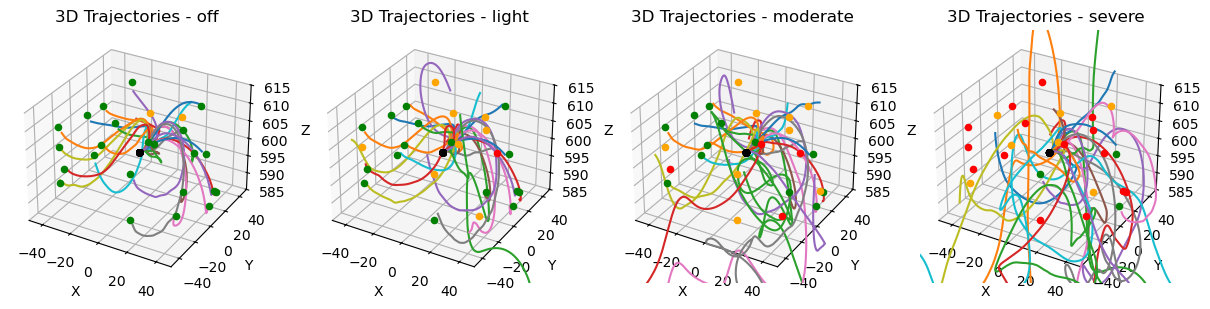

In [7]:
plot_frames = False
fig = metrics.plot_trajectories(enu_positions, orientations, targets_enu, target_success, severity_range, plot_frames)
plt.show()